# Comparação de Estratégias de Seleção de Instâncias em Aprendizado Ativo

## Imports

In [1]:
import os
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output

## Reunindo Resultados para Comparação

In [2]:
RESULTS_DIR = '../../scripts/results/'

Por hora, seram analisados apenas as queries que utilizaram um determinado algoritmo (KNN) como aprendiz

## Definições

In [77]:
from collections import namedtuple

ResultFiles = namedtuple('ResultFiles', 'v1 v2')

In [102]:
def get_result_files(pattern):
    result_files = ! find $RESULTS_DIR -maxdepth 2 -type f | grep $pattern
    result_files = sorted(result_files)
    return result_files

In [3]:
styles = ['*-', 's-', '^-', 'v-', 'D-', 'P-', '--', 'X-']

### Análise Descritiva das Recomendações

In [135]:
def describe_results(result_files):
    df = pd.concat(pd.read_csv(f) for f in result_files).filter(like='choice')
    df = df.apply(pd.value_counts)
    df = df.transform(lambda x: x.div(sum(x)))
    return  df.sort_index()

### Curvas de Aprendizado

In [165]:
def plot_learning_curves(result_files, id=None):
    dfs = [pd.read_csv(file, index_col=0) for file in result_files]
    
    dfs =  [df.loc[:, ~df.columns.str.contains('choice')] for df in dfs]

    for f, df in zip(result_files, dfs):
        dataset_id, _ = os.path.basename(f).split('.')
        
        if id == None:
            pass
        elif dataset_id == str(id):
            pass
        else:
            continue
            
        df.plot(ylim=(0,1.2), grid=True, style=styles, alpha=0.8, figsize=(16,6),
                title=f'Curva de Aprendizado ({dataset_id})').legend(loc=4, prop={'size': 8})
        
        display(plt.gcf())
    
        if id or (input('Pressione Enter para continuar...')) == 'q':
            break
    
        clear_output(wait=True)
        
        plt.close()
    plt.close()

### Curvas de Ranqueamento

In [55]:
def plot_ranking_curves(result_files):
    
    dfs = [pd.read_csv(file, index_col=0) for file in result_files]
    
    dfs =  [df.loc[:, ~df.columns.str.contains('choice')] for df in dfs]

    ranks_df = sum(df.rank(axis=1, ascending=False) for df in dfs)/len(dfs)

    ranks_df.plot(style=styles, grid=True, figsize=(16,6), title='Curvas de Ranqueamento').legend(loc=2)
    
    plt.gca().invert_yaxis()
 

### Curvas de Ganho

In [7]:
def gen_auc_df(file):
    auc_dict = dict()
    results = pd.read_csv(file)
    strategies = [c for c in results.columns if not 'choice' in c and not 'Unnamed' in c]
    
    for s in strategies:
        auc_dict[s] = [np.trapz(results[s][:i+1]) for i in range(len(results[s]))]
    auc_df = pd.DataFrame(auc_dict)
    
    return auc_df.sub(auc_df.random_sampling, axis=0)

        

In [8]:
def display_graph(df,i, total, file ):
    df.plot(grid=True, figsize=(16, 6),
            title=f'Ganho F1-macro X Query ({file if file else "Medio"}) [{i+1}/{total}]',
            style=styles, alpha=0.5 )
    
def display_all_graphs(learner_result_files):

    for i, f in enumerate(learner_result_files):
        auc_df = gen_auc_df(f)

        display_graph(auc_df, i, len(learner_result_files), f)
        
        display(plt.gcf())
    
        if (input('Pressione Enter para continuar...')) == 'q':
            break
    
        clear_output(wait=True)
        
        plt.close()
    plt.close()

In [9]:
def summary_graph(learner_result_files, ax, title):
    
    mean_dict, std_dict = dict(), dict()
    df_list = []
    for f in learner_result_files:
        df_list.append(gen_auc_df(f))

    strategies = df_list[0].columns

    for s in strategies:
        df = pd.concat([e[s] for e in  df_list], axis=1)
        mean_dict[s] = df.mean(axis=1)
        std_dict[s] = df.std(axis=1)


    pd.DataFrame(mean_dict).plot(grid=True, style=styles, alpha=0.5, ax=ax, sharey=True, title=title)

### Mapas de Calor

#### Visualização de Queries

In [10]:
def plot_heat_map(df, ax, title, result_files, value_to_int):

    cmap = sns.color_palette(n_colors=len(value_to_int))
    
    new_columns = [os.path.basename(f) for f in result_files]
    new_df = df.replace(value_to_int)
    new_df.columns = new_columns
    
    sns.heatmap(new_df.T, linewidth=.1, cmap=cmap,ax=ax, vmin=0, vmax=len(value_to_int))
                                             
    
    colorbar = ax.collections[-1].colorbar 
    n = len(value_to_int)
    r = colorbar.vmax - colorbar.vmin 
    colorbar.set_ticks([colorbar.vmin + r / n * (0.5 + i) for i in range(n)])
    colorbar.set_ticklabels(list(value_to_int.keys()))

    ax.set_title(title)

In [11]:
def plot_heat_maps(result_files):
    result_files = sorted(result_files)
    df = pd.concat([pd.read_csv(f, index_col=0).filter(like='choice') for f in result_files], axis=1)
    df.fillna('NaN', inplace=True)
    value_to_int = {j:i for i, j in enumerate(sorted(pd.unique(df.values.ravel()), reverse=True))}

    
    fig, axs = plt.subplots(1,2)
    fig.set_size_inches(40,20)
    plot_heat_map(df['meta_sampling_choice'], axs[0], 'Meta-sampling', result_files, value_to_int)
    plot_heat_map(df['perfect_sampling_choice'], axs[1], 'Perfect Meta-sampling', result_files, value_to_int)
    

#### Visualiação de Acertos

In [159]:
from functools import partial

def sequence_only(row, tolerance):
    error_count = 0
    for i, e in enumerate(row):
        
        if not e:
            error_count+=1
            
        if error_count > tolerance:
            row[i:] = 2
            
    return row

from matplotlib.colors import ListedColormap

def plot_acc_heatmap(result_files, tolerance=0):
    dfs = [(os.path.basename(file), pd.read_csv(file).filter(like="choice"))
           for file in result_files]

    # Lida com resultados da v1
    for _, df in dfs:
        if 'meta_sampling_ideal_choice' not in df.columns:
            df['meta_sampling_ideal_choice'] = df.perfect_sampling_choice
    
    result = [(df.meta_sampling_choice == df.meta_sampling_ideal_choice).rename(file_name)
              for file_name, df in dfs]

    result_df = pd.DataFrame(result, dtype=int)

    acc = result_df.values.sum()/result_df.size
    
    cmap = ListedColormap(['red', 'green', '0.8'])
    
    result_df.apply(partial(sequence_only, tolerance=tolerance), axis=1)
    
    fig, ax = plt.subplots(figsize=(15,20))

    sns.heatmap(result_df, ax=ax, linewidth=.1, cmap=cmap, vmin=0, vmax=2, cbar=False)
    
    ax.set_title(f'Acertos Sequenciais (acc = {acc})')

## Naive Bayes

In [106]:
result_files_nb = ResultFiles(get_result_files('GaussianNB_v1/'),
                              get_result_files('GaussianNB/'))

len(result_files_nb.v1), len(result_files_nb.v2)

(100, 100)

### Curvas de Ranqueamento

- **Dúvida**: V2 é overfitting? De fato, com a v2 estamos gerando novos dados rotulados, mas num ponto de vista prático em que o método vai ser utilizado, não faria sentido para o oráculo se utilizar de todas as estratégias, anotar todos esse dados e ver qual impacta mais no resultado. Dessa forma, embora os resultados estejam melhores, eles são realistas?

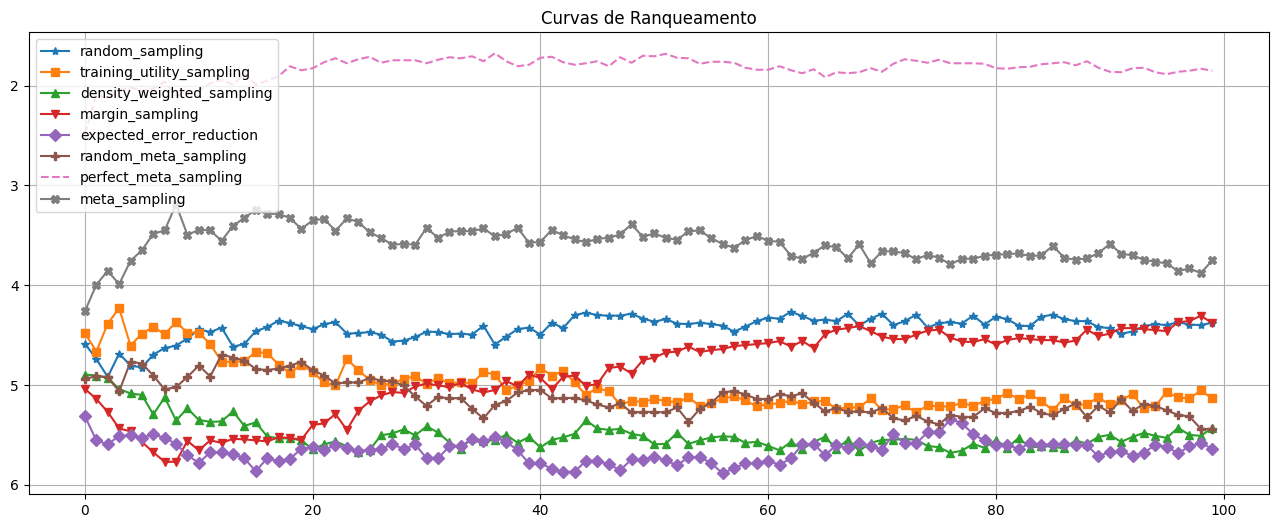

In [171]:
plot_ranking_curves(result_files_nb.v2)

### Acurácia Sequencial

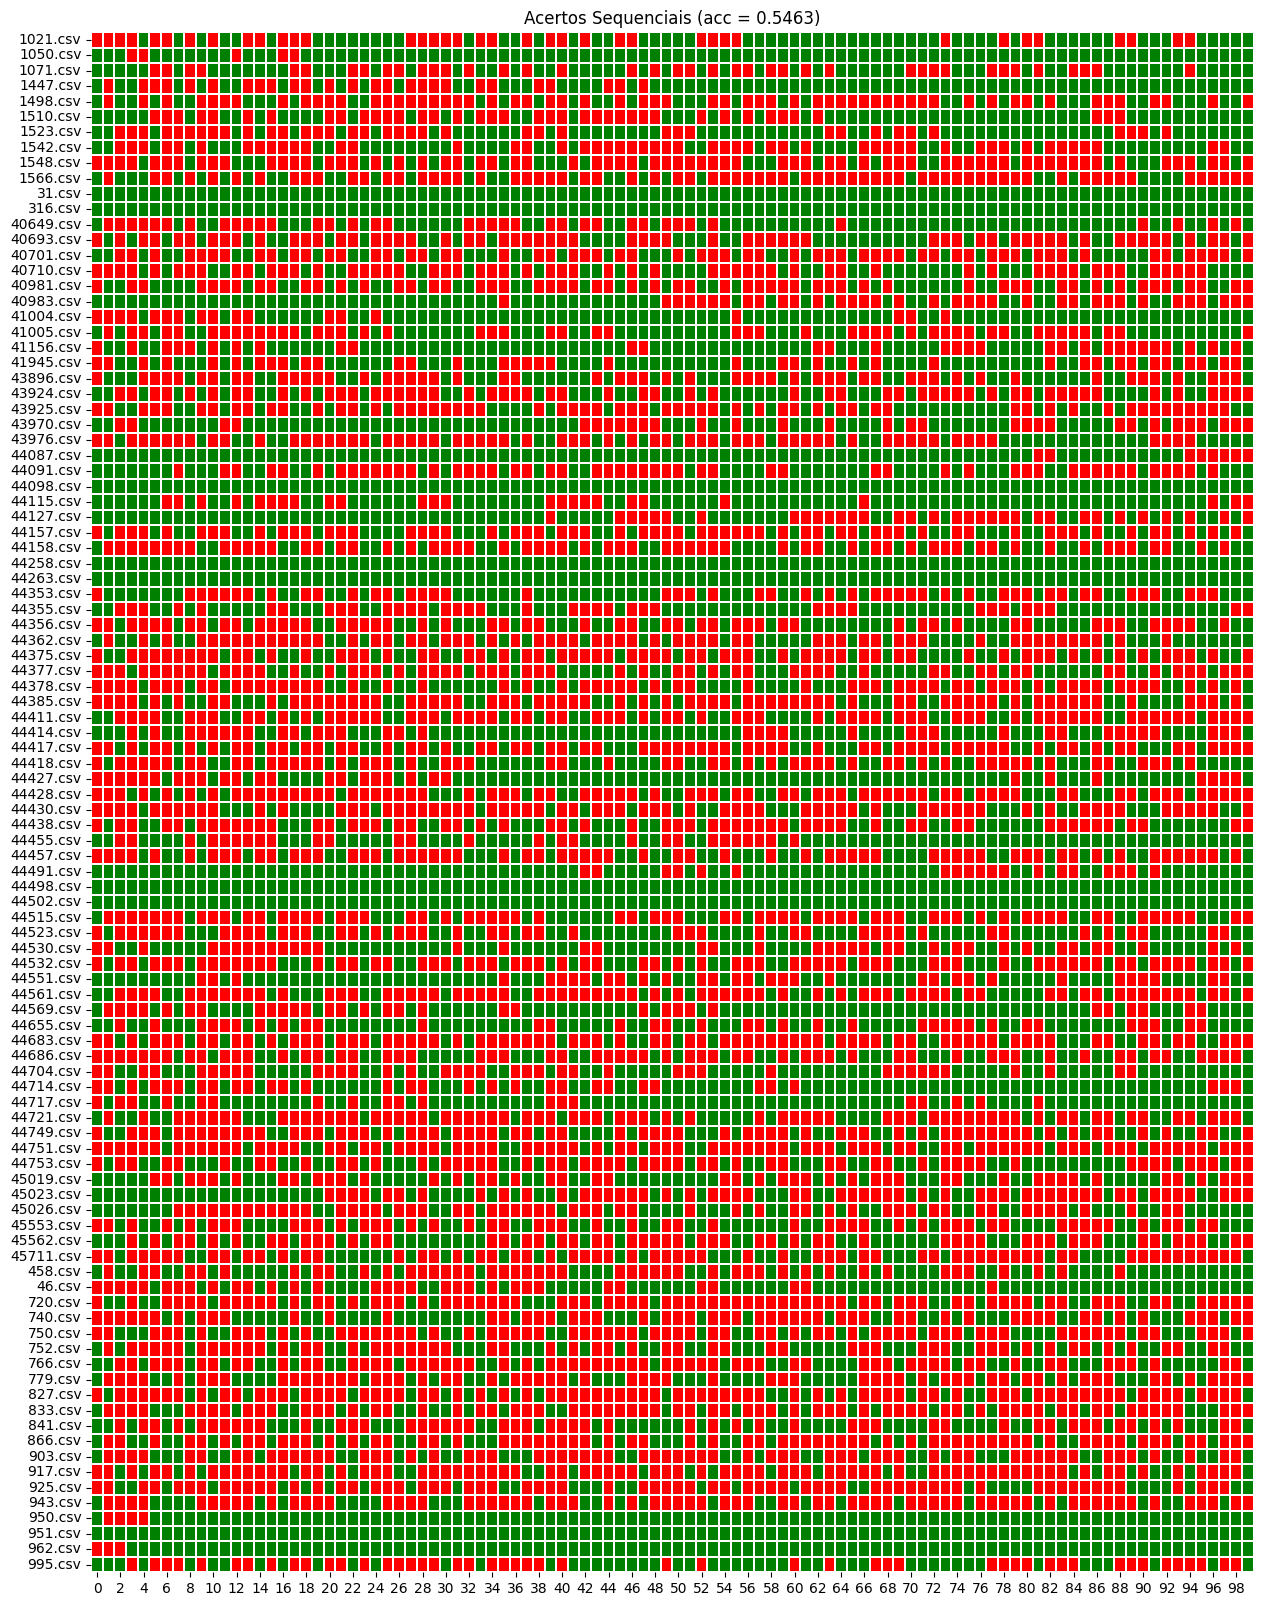

In [169]:
result = plot_acc_heatmap(result_files_nb.v2, tolerance=100)

### Curvas de Aprendizado

- **NOTA**: Em algumas bases, as estratégias se comportam de forma muito similar, isso pode afetar a acurácia calculada acima, visto que muitos erros podem ser escolhidos por ter um desempenho muito próximo a melhor escolha de fato (Ex: base 962)
- **NOTA 2**: Base 962 foi muito melhor na v1 do que na v2

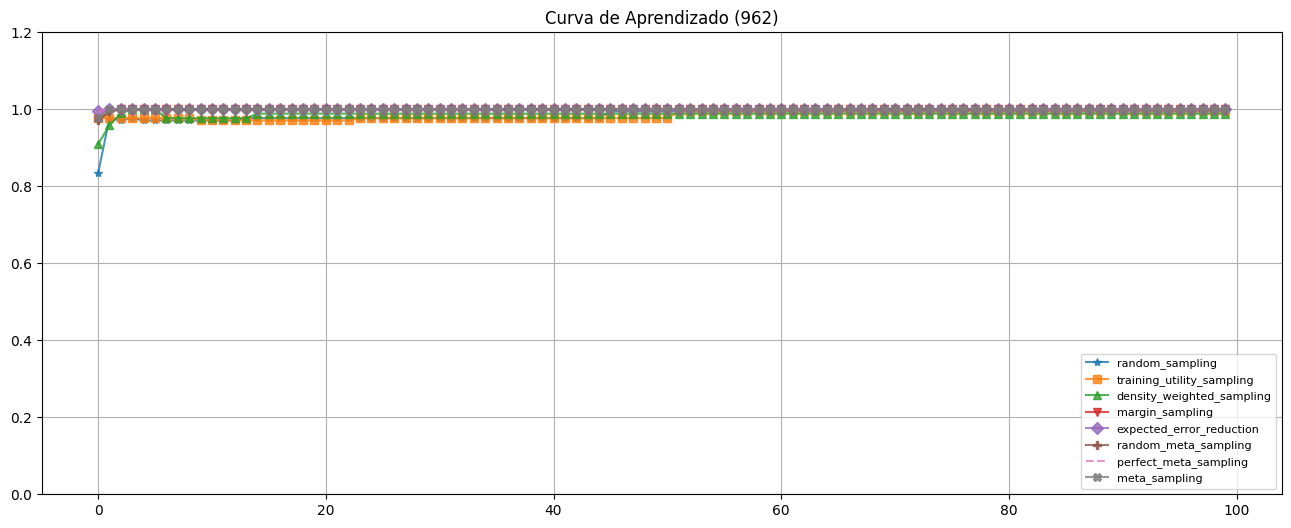

In [166]:
plot_learning_curves(result_files_nb.v2, 962)

### Visualização de Predições

Meta-sampling ainda recomenda estratégia baseada em incerteza com mais frequência

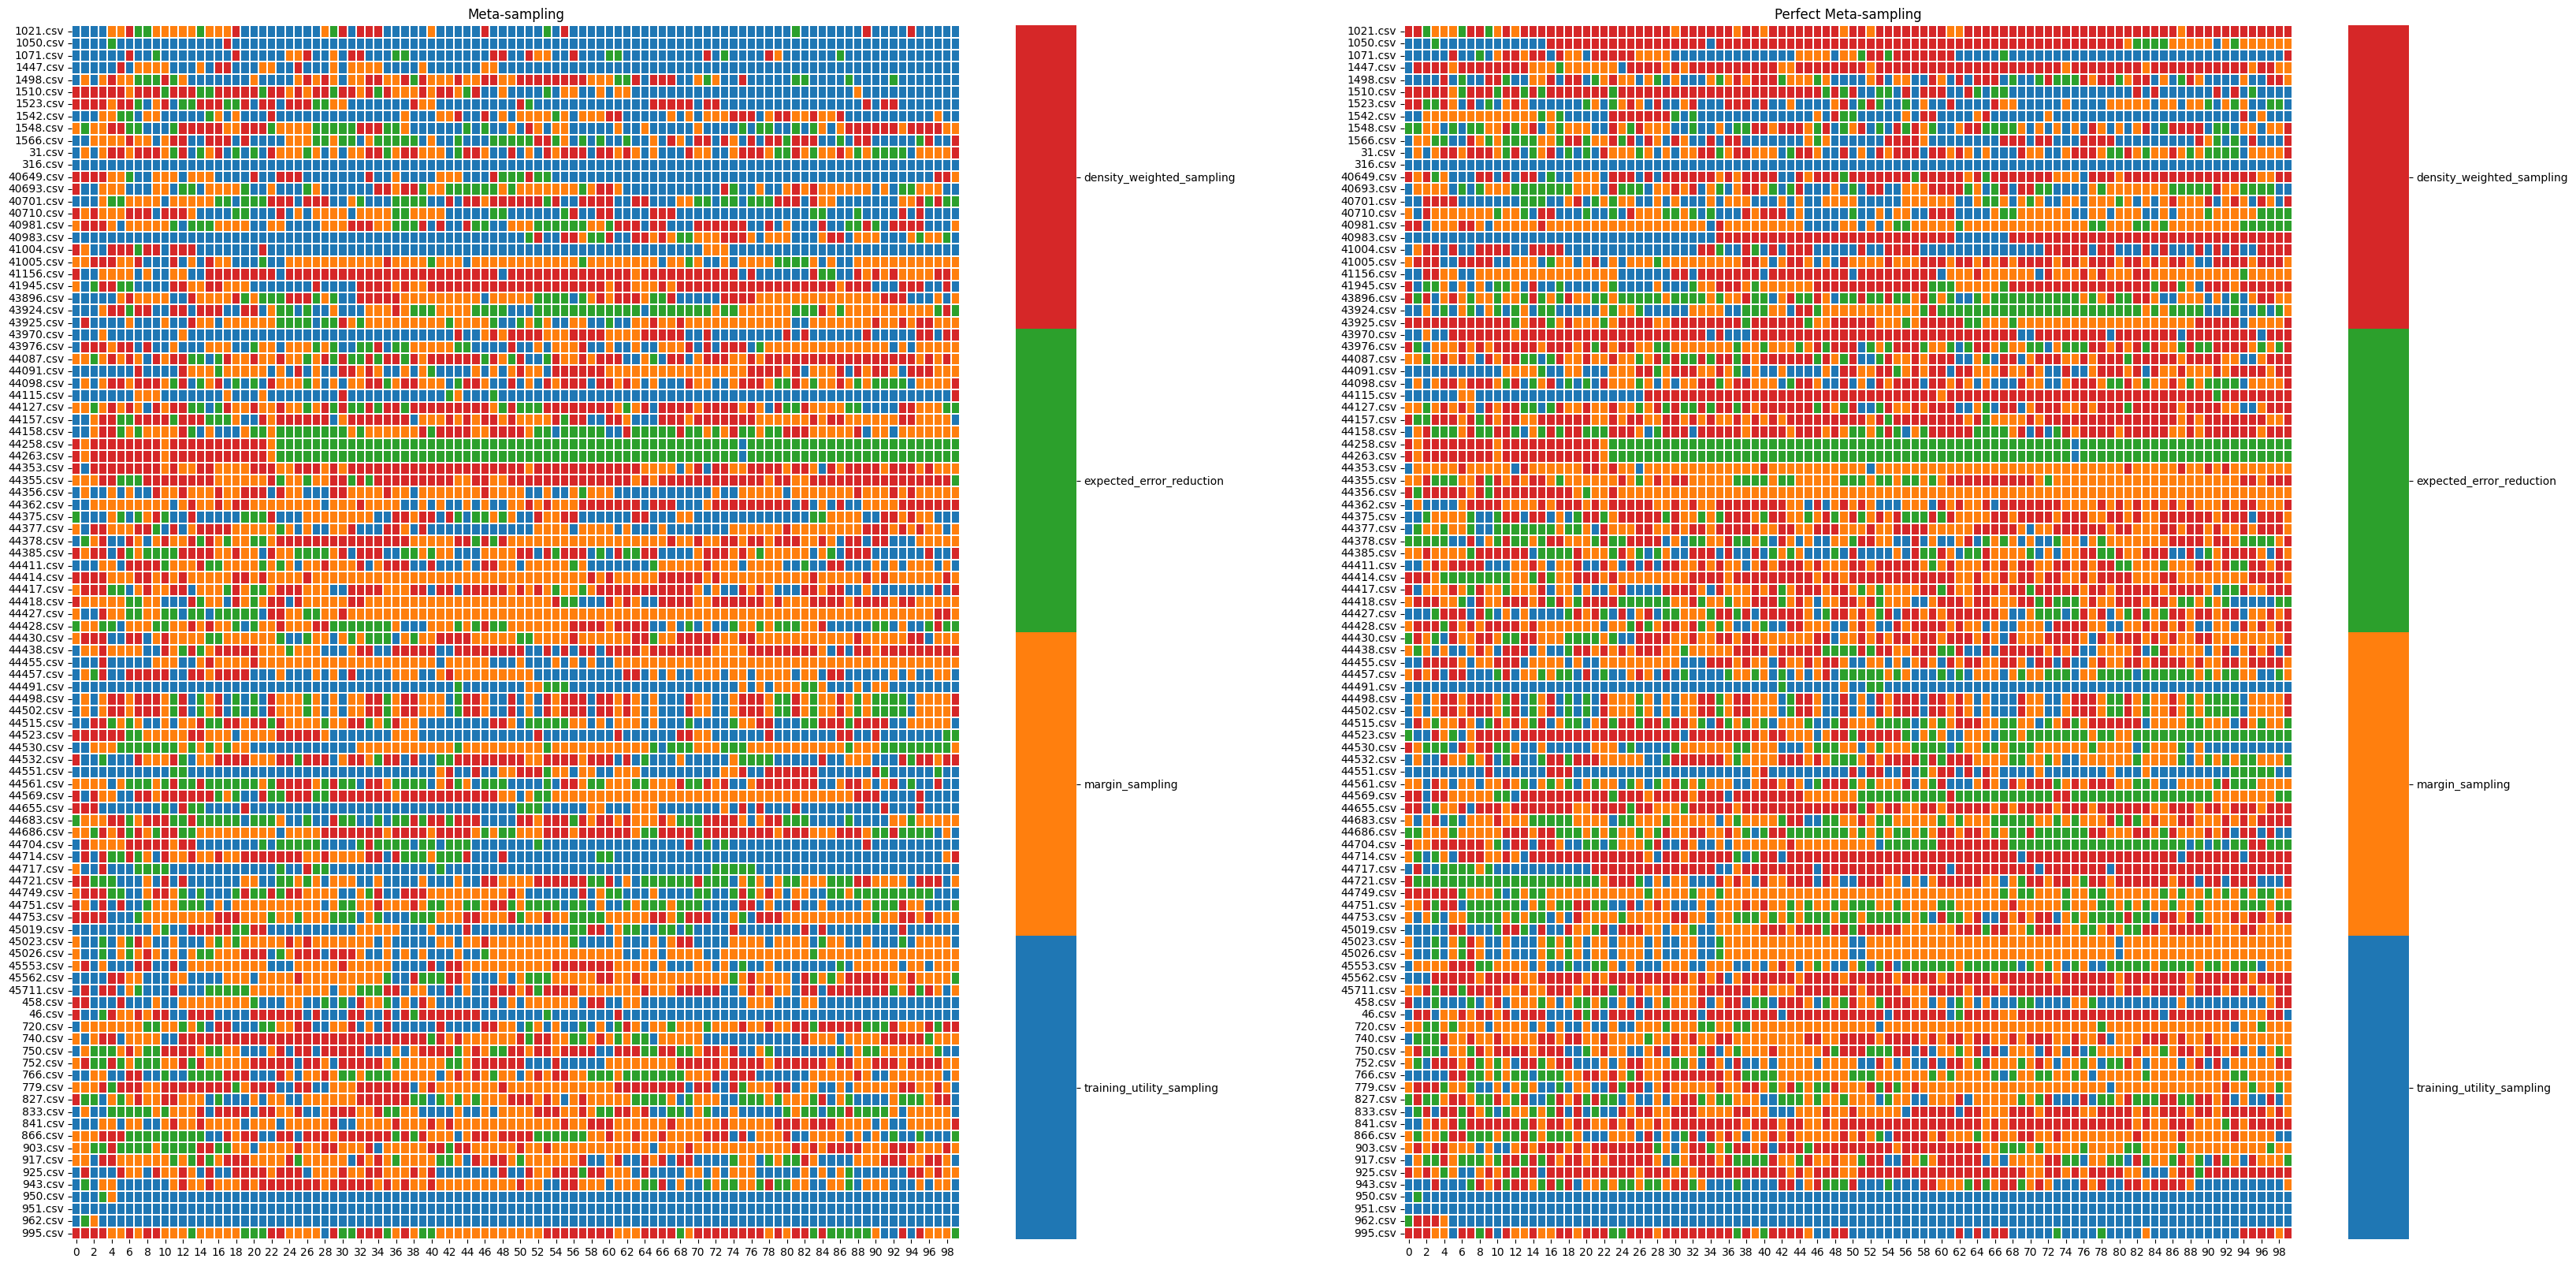

In [167]:
plot_heat_maps(result_files_nb.v2)

### Análise descritiva das recomendações

In [136]:
describe_results(result_files_nb.v1)

,random_sampling_choice,perfect_sampling_choice,meta_sampling_choice
density_weighted_sampling,0.2502,0.3324,0.3163
expected_error_reduction,0.2549,0.1489,0.0577
margin_sampling,0.2420,0.3059,0.4785
training_utility_sampling,0.2529,0.2128,0.1475


In [137]:
describe_results(result_files_nb.v2)

,random_sampling_choice,perfect_sampling_choice,meta_sampling_choice,meta_sampling_ideal_choice
density_weighted_sampling,0.2574,0.3324,0.2289,0.2295
expected_error_reduction,0.2467,0.1489,0.1232,0.1432
margin_sampling,0.2456,0.3059,0.2984,0.2658
training_utility_sampling,0.2503,0.2128,0.3495,0.3615


## KNN

In [25]:
result_files_knn = ! find $RESULTS_DIR -type f | grep KNei
result_files_knn = sorted(result_files_knn)
len(result_files_knn) 

100

### Curvas de Ranquamento

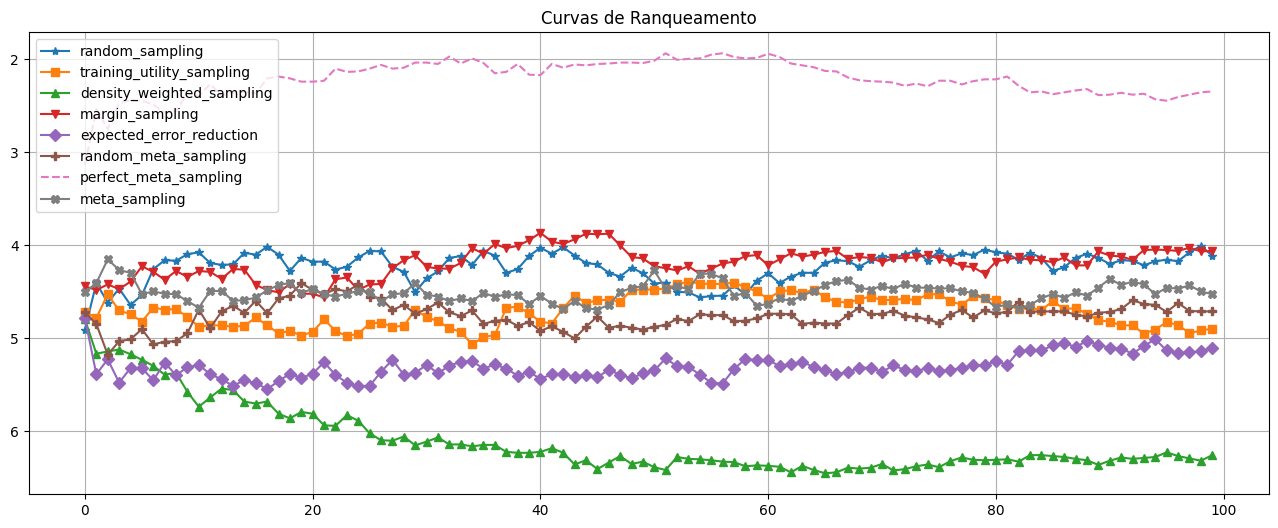

In [26]:
plot_ranking_curves(result_files_knn)

### Acurácia Sequêncial

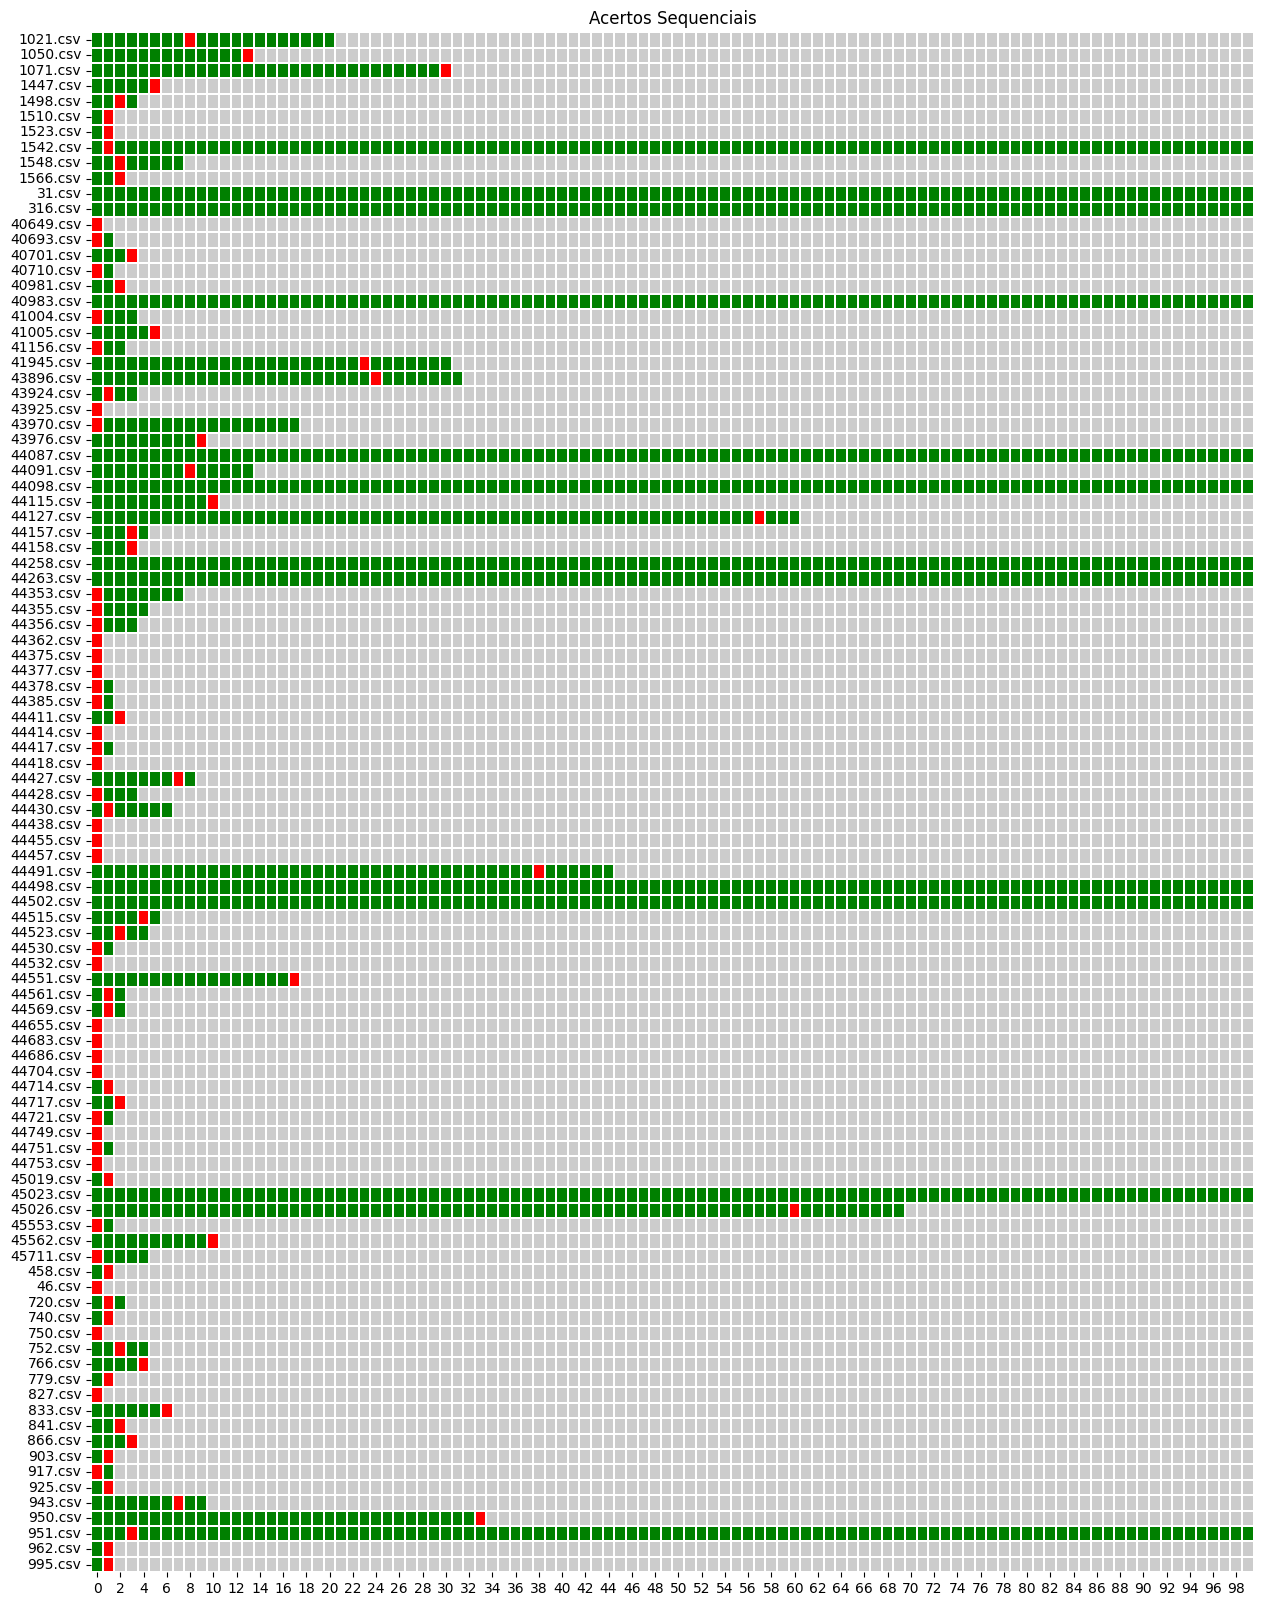

In [54]:
plot_acc_heatmap(result_files_knn, tolerance=1)

### Curvas de Aprendizado

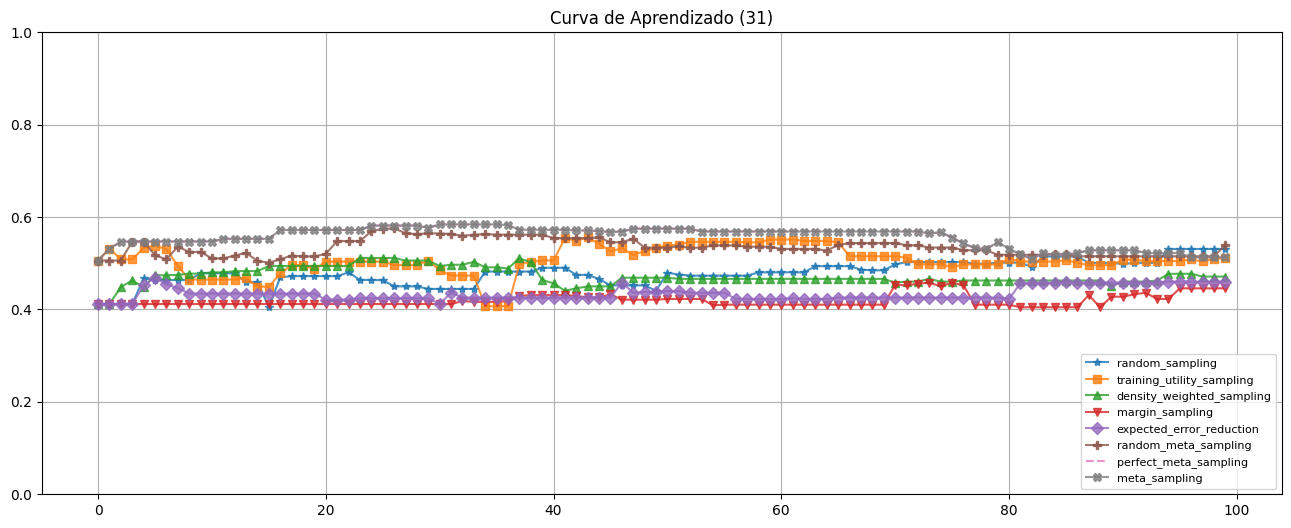

In [48]:
plot_learning_curves(result_files_knn, id='31')

### Visualização de Predições

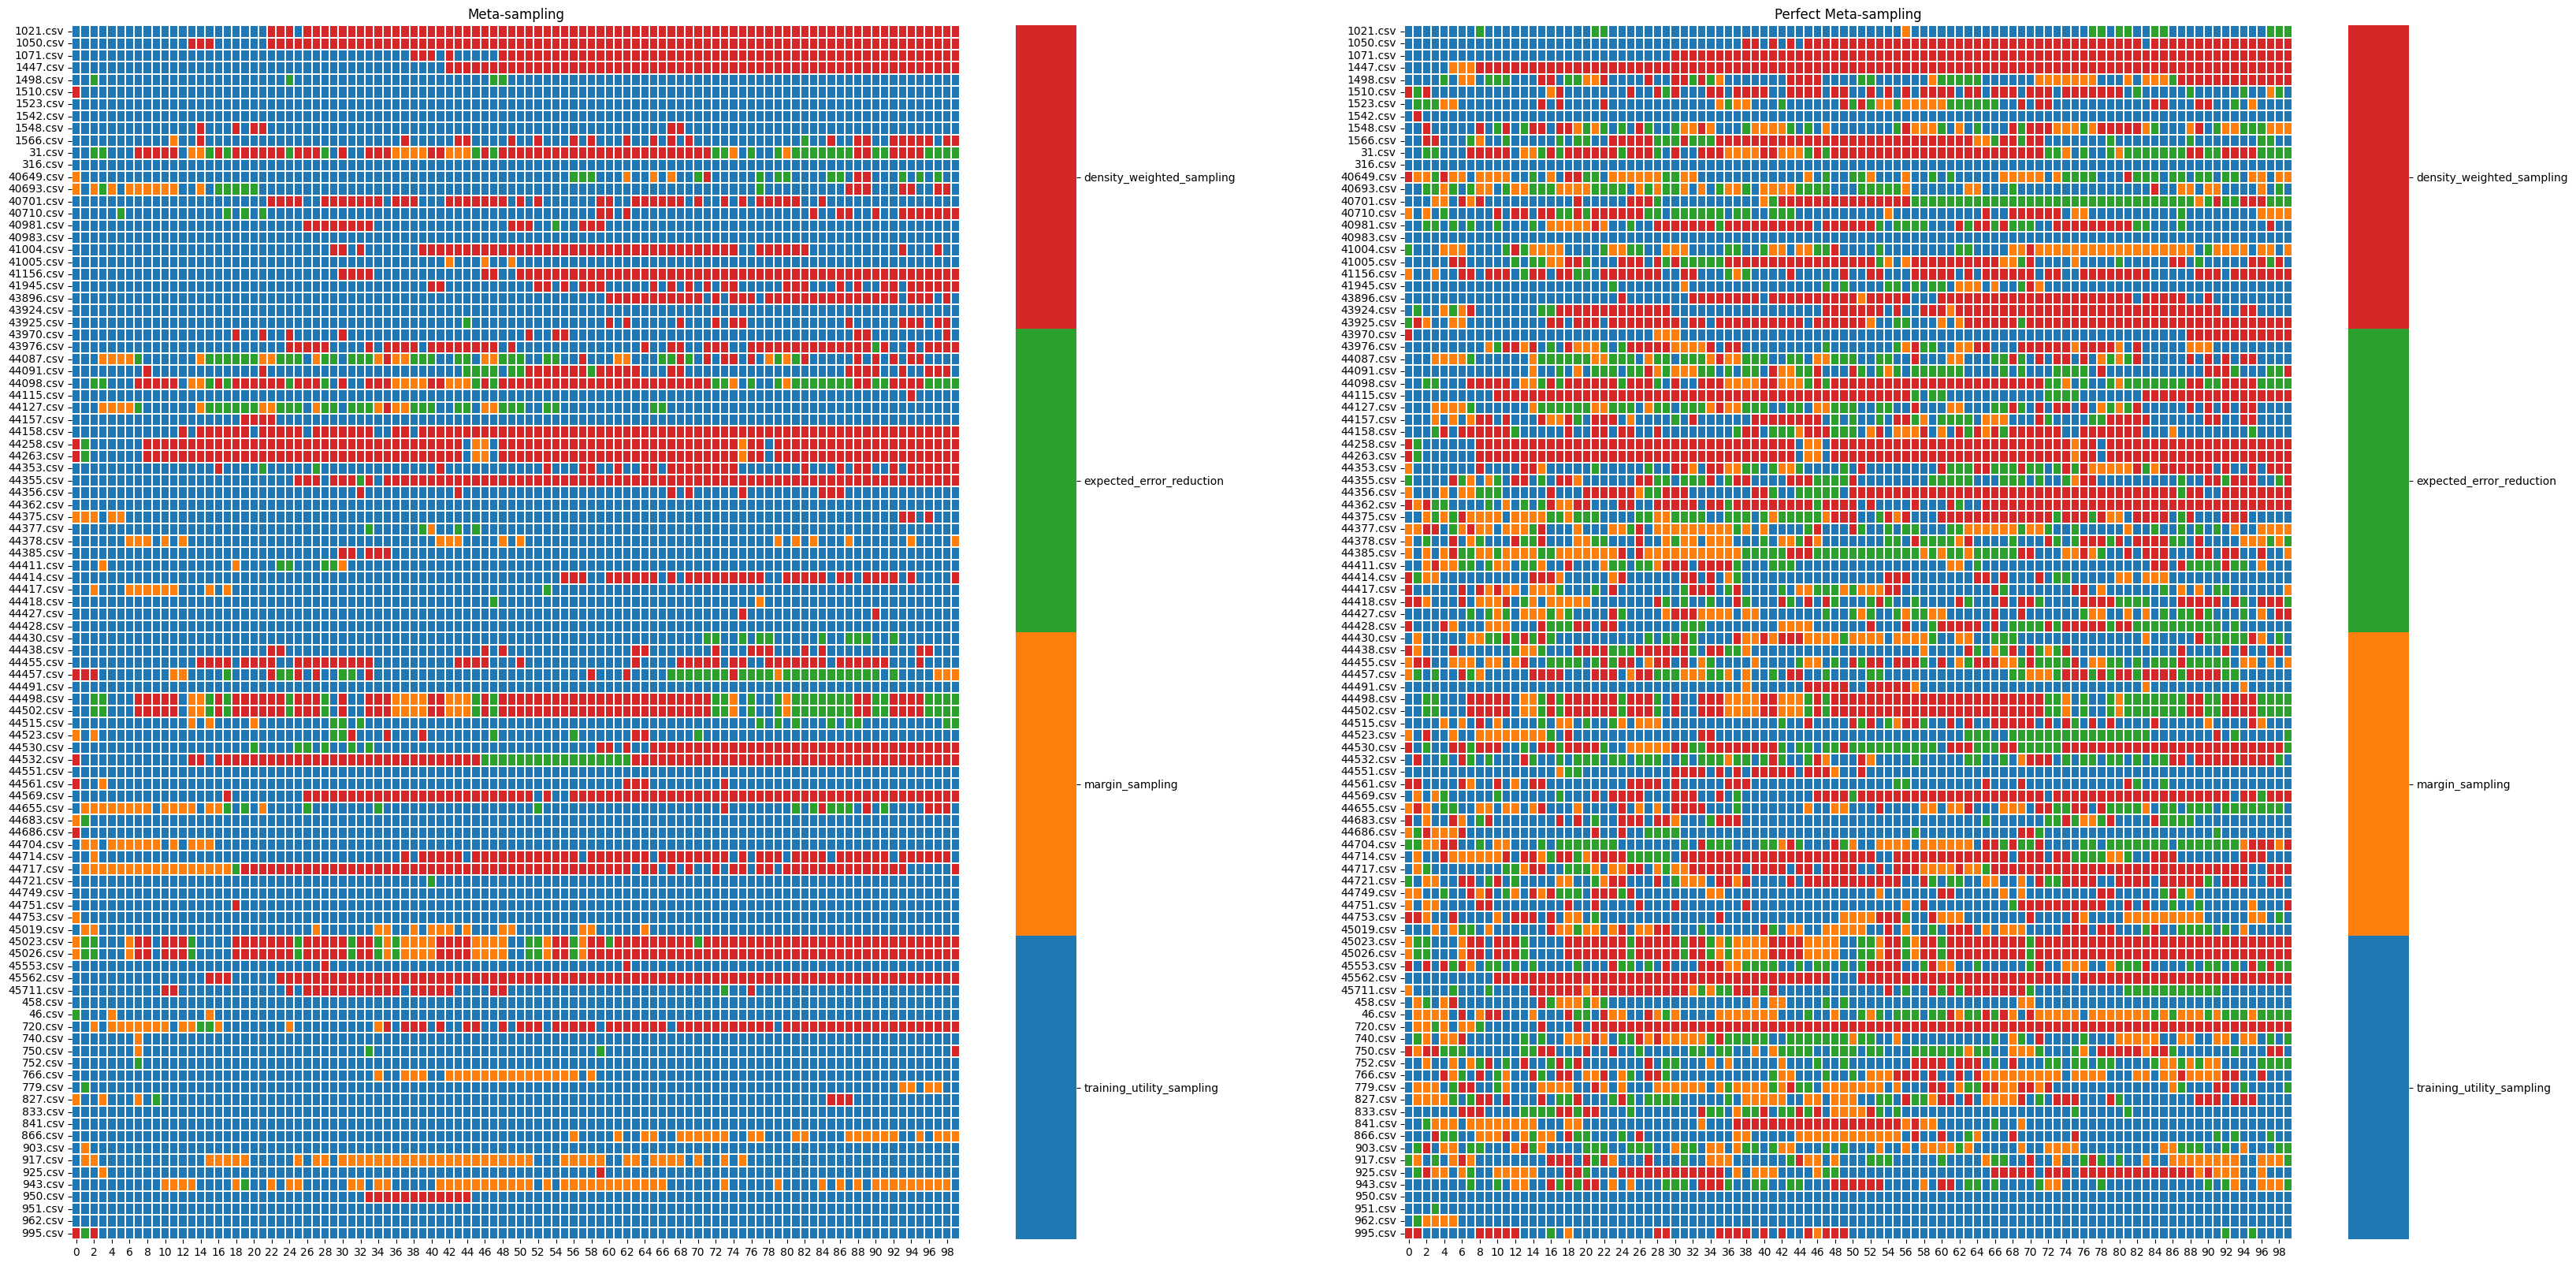

In [29]:
plot_heat_maps(result_files_knn)

### Análise Descritiva das Recomendações

In [30]:
describe_results(result_files_knn)

,random_sampling_choice,perfect_sampling_choice,meta_sampling_choice
training_utility_sampling,0.2607,0.4672,0.7305
density_weighted_sampling,0.2463,0.2768,0.1962
margin_sampling,0.2493,0.1152,0.0399
expected_error_reduction,0.2437,0.1408,0.0334


## Árvore de Decisão

In [31]:
result_files_dt = ! find $RESULTS_DIR -type f | grep Decision
result_files_dt = sorted(result_files_dt)
len(result_files_dt) 

100

### Curvas de Ranqueamento

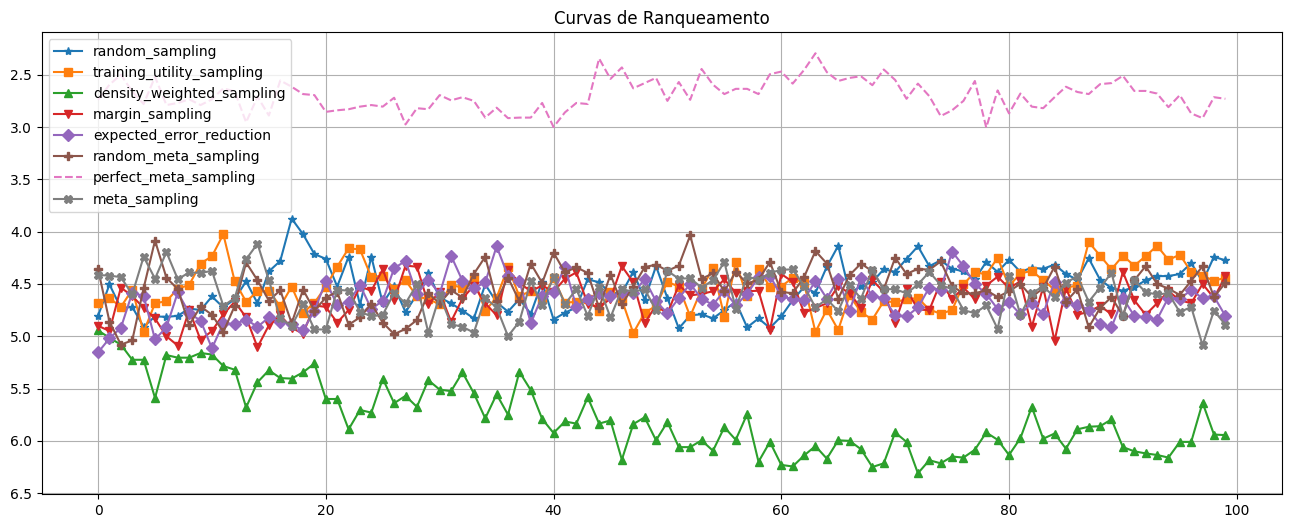

In [32]:
plot_ranking_curves(result_files_dt)

### Acurácia Sequêncial

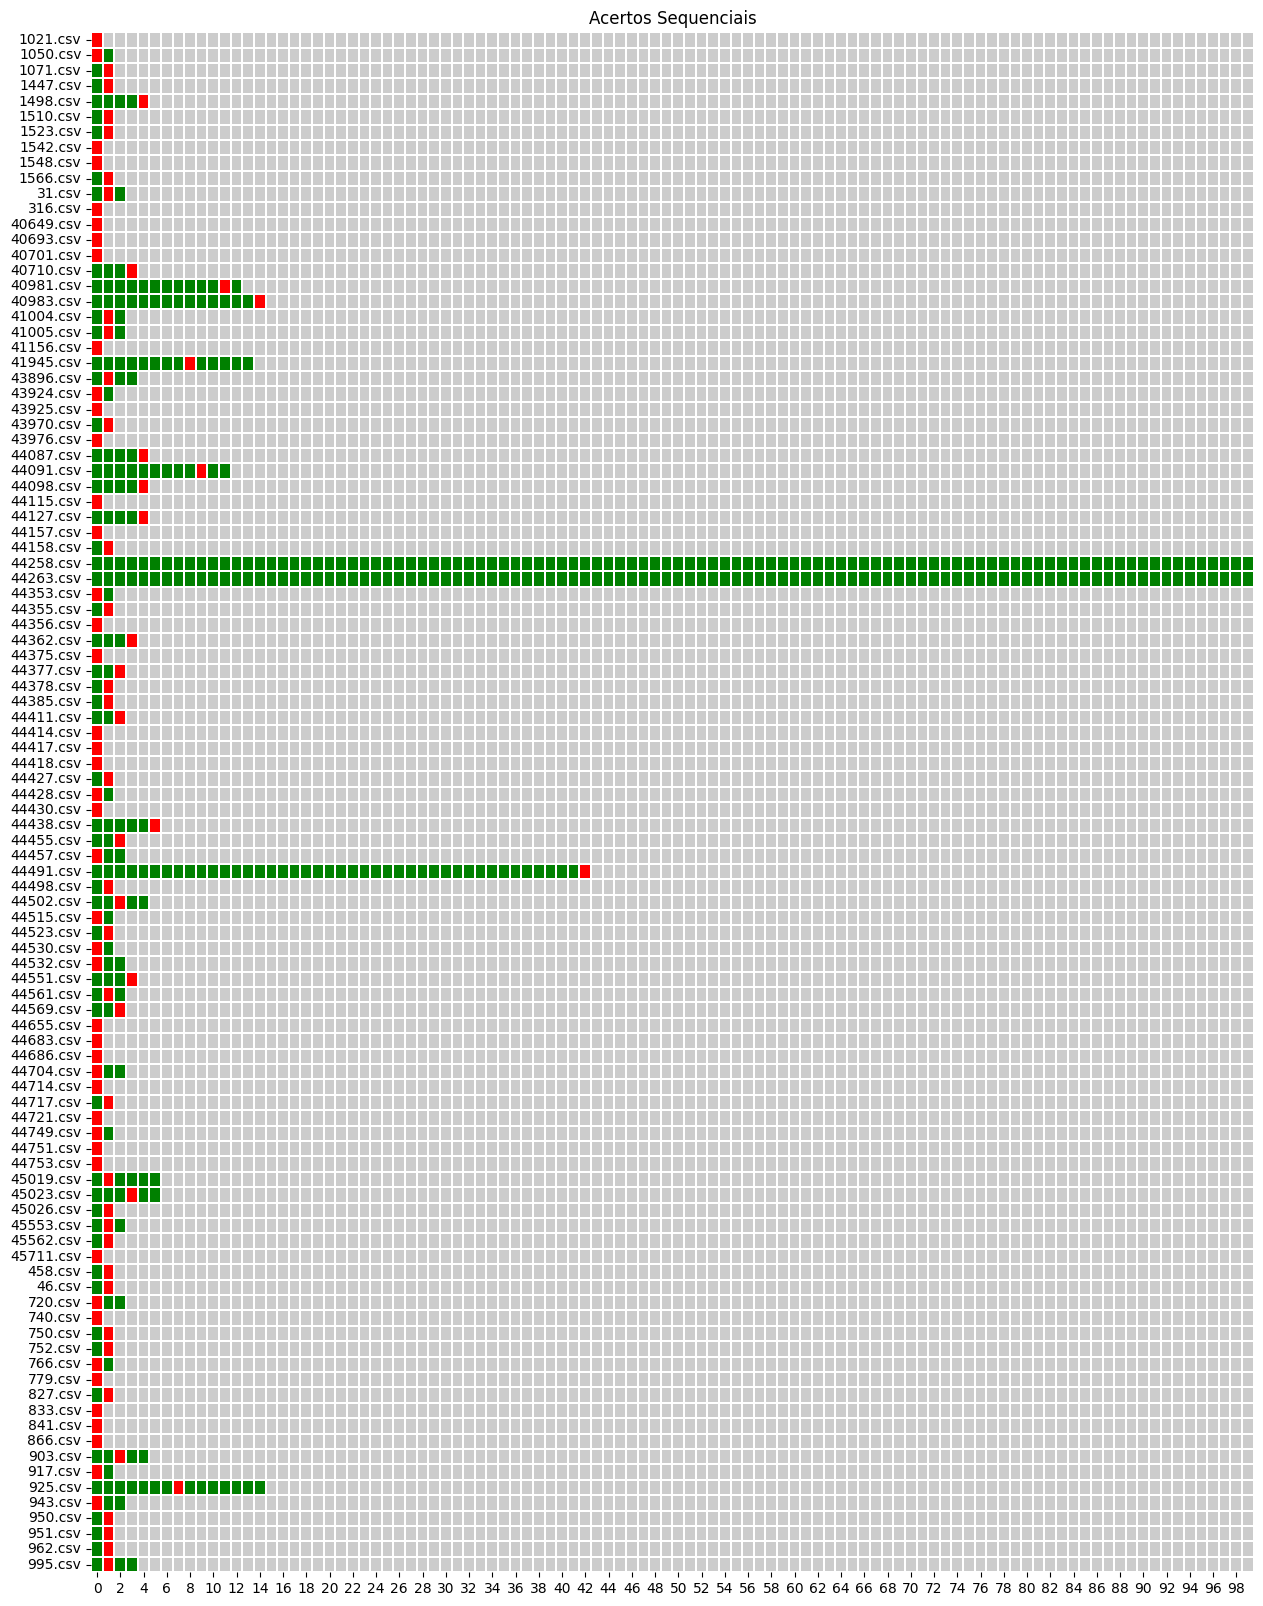

In [34]:
plot_acc_heatmap(result_files_dt, tolerance=1)

### Curvas de Aprendizado

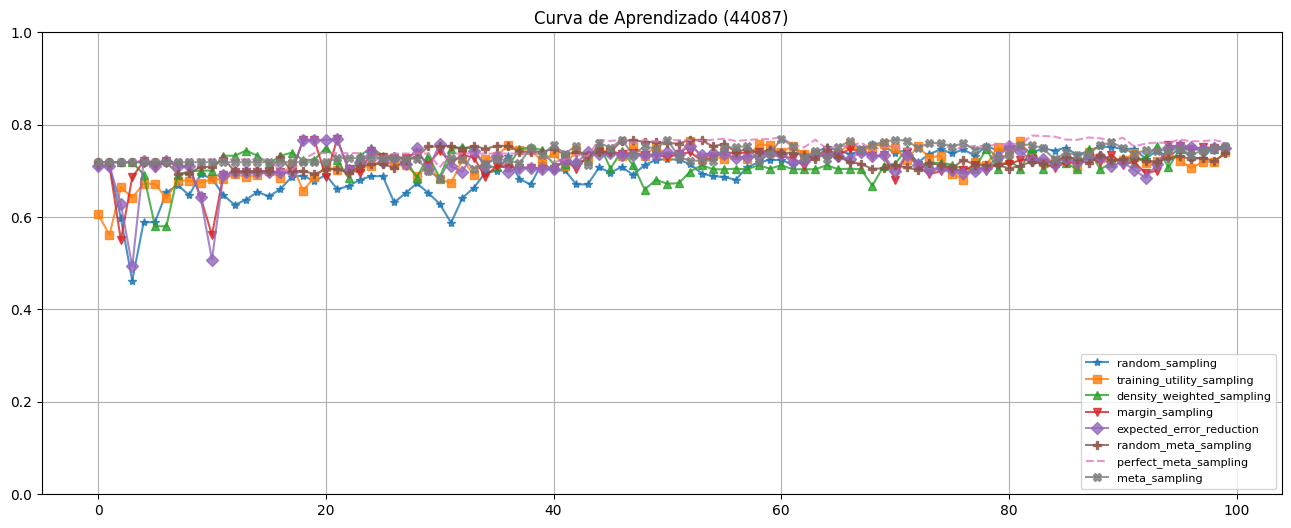

In [35]:
plot_learning_curves(result_files_dt, id='44087')

### Visualização de Predições

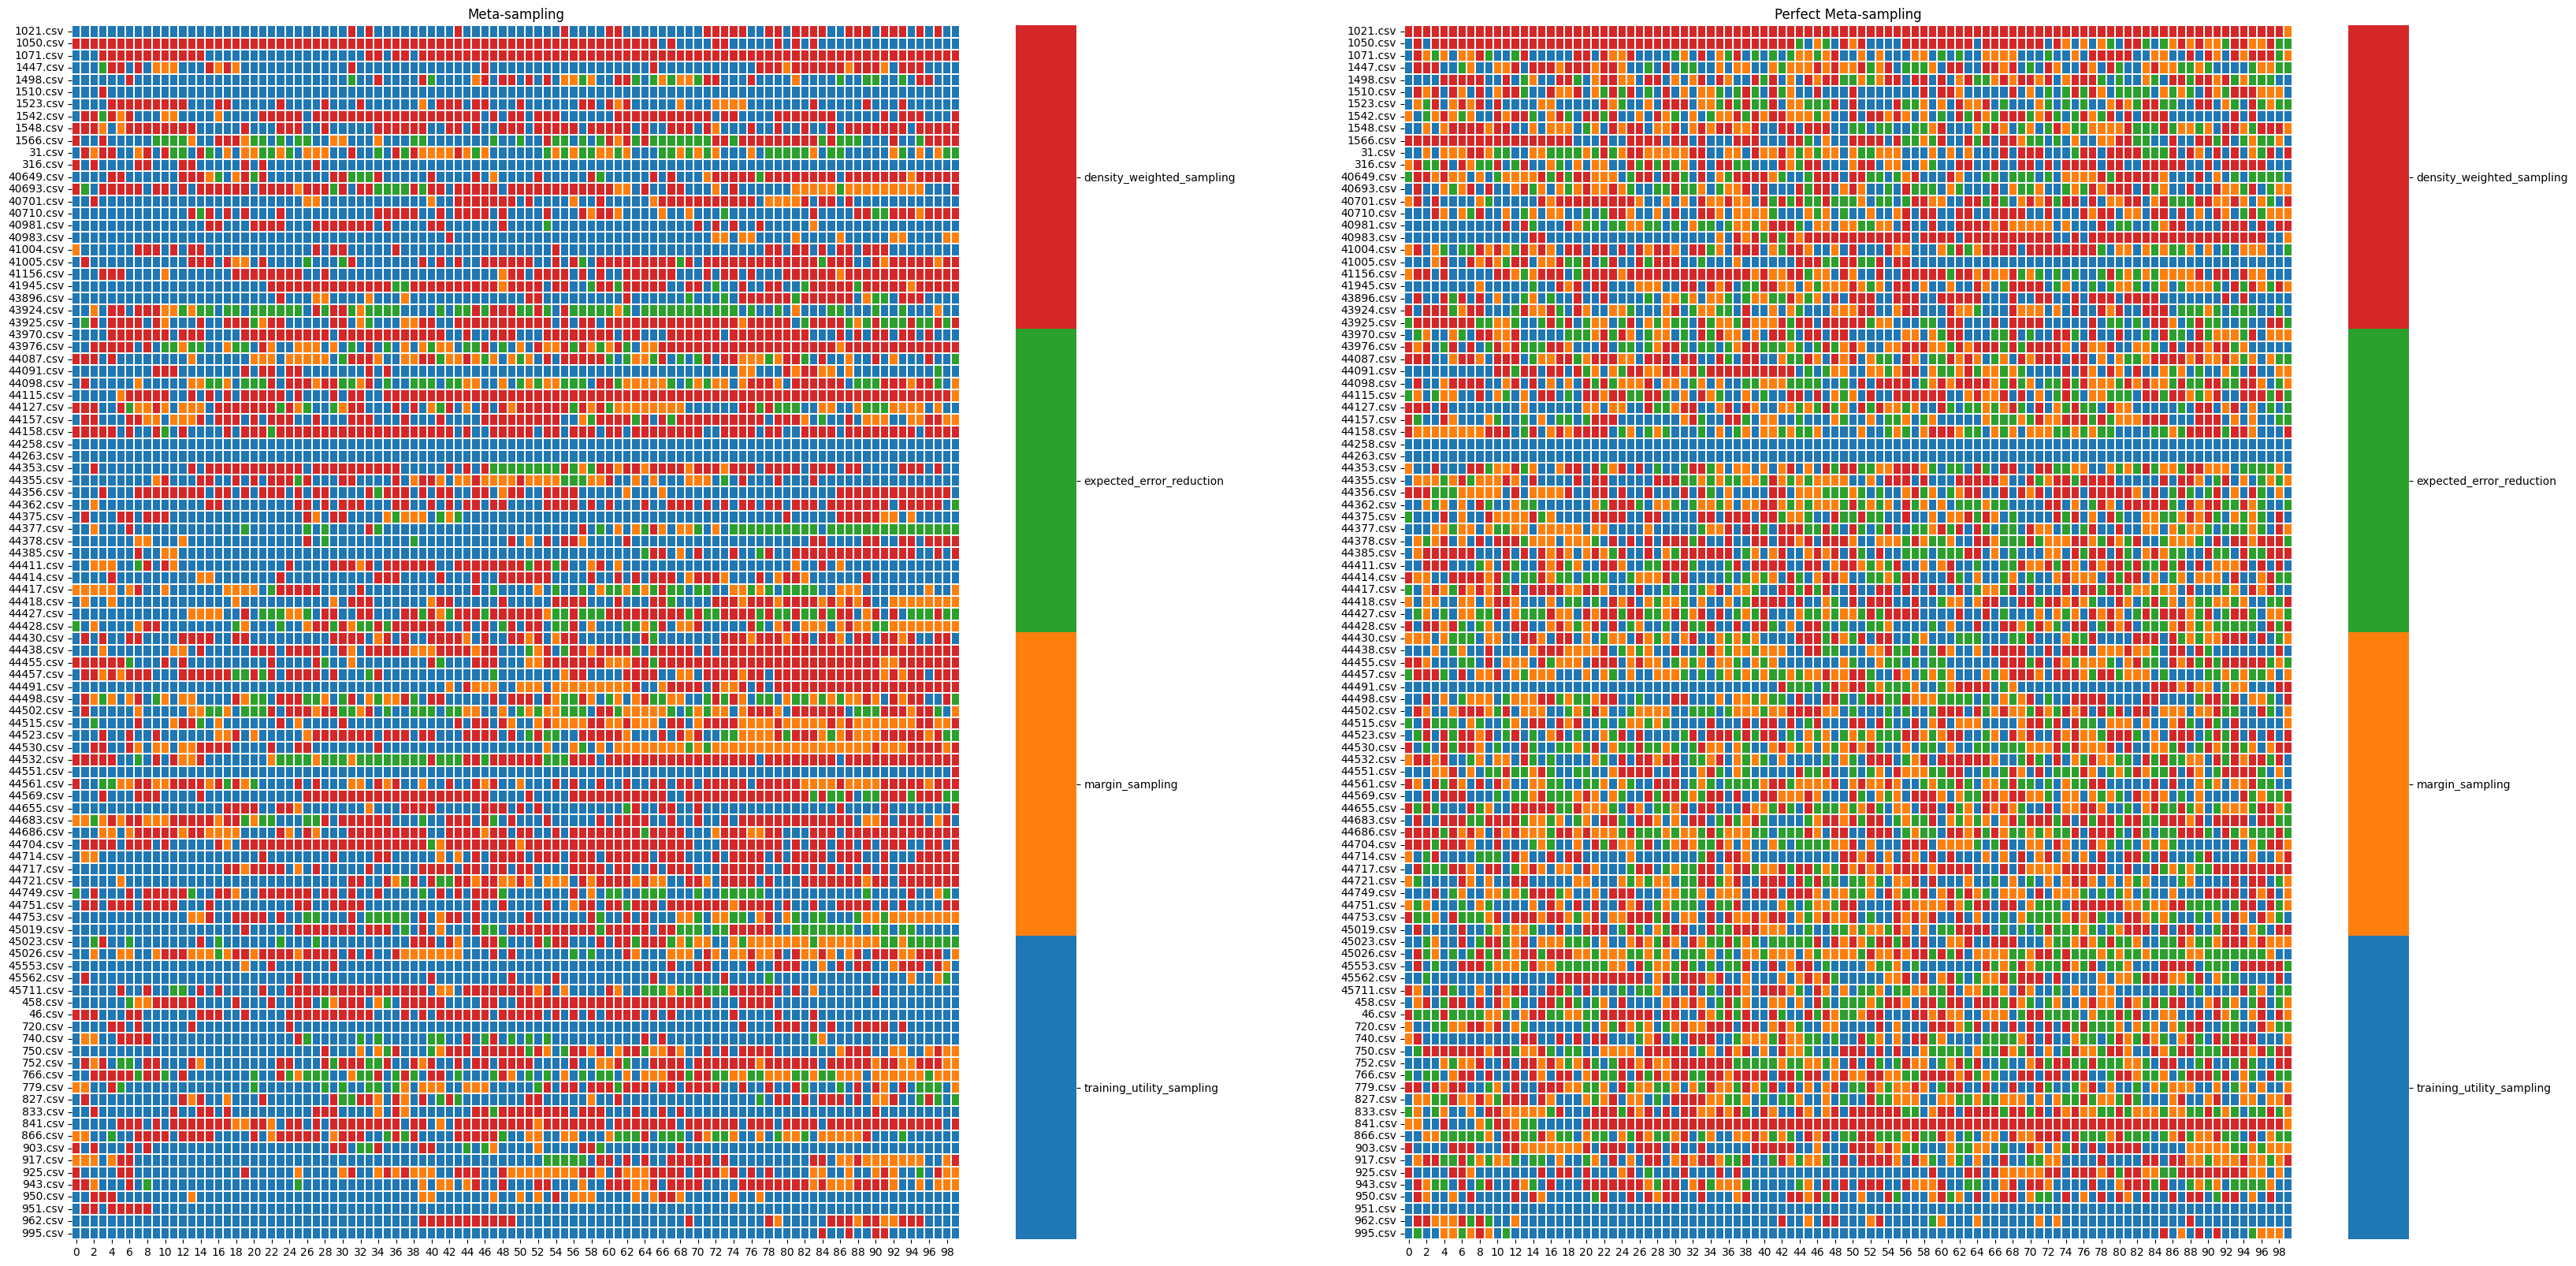

In [37]:
plot_heat_maps(result_files_dt)

### Análise Descritiva das Recomendações

In [38]:
describe_results(result_files_dt)

,random_sampling_choice,perfect_sampling_choice,meta_sampling_choice
training_utility_sampling,0.2616,0.3382,0.5146
density_weighted_sampling,0.2441,0.2827,0.3231
margin_sampling,0.2507,0.2000,0.0944
expected_error_reduction,0.2436,0.1791,0.0679
